In [26]:
SEARCH_TERM = "America"
TWEETS_COUNT = 300
TIME_LIMIT = 120



import keys
import os
from credentials import *
import pandas as pd
import numpy as np
import tweepy
from tweepy import OAuthHandler
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

dir_path = os.getcwd()
dir_path_data = dir_path + "/Data/"


consumer_key = keys.consumer_key
consumer_secret = keys.consumer_secret
access_token = keys.access_token
access_secret = keys.access_secret


# print(consumer_key)
# print(consumer_secret)
# print(access_token)
# print(access_secret)


print(dir_path)
print(dir_path_data)

 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)




C:\sjsu-git\ML_Project
C:\sjsu-git\ML_Project/Data/


In [2]:
# Before running this code
# make a directory named Data and provide the path of the directory at INPUT_DATAPATH
# set SEARCH_TERM as what you would like to search from twitter "ex: apple"
# which would produce the list of tweets for the term "apple" 
# and also store the twitter data into the file stream_apple.json in the directory of INPUT_DATAPATH


from tweepy import Stream
from tweepy.streaming import StreamListener
import time
import string
import json
import time
import os


class MyListener(StreamListener):
    """Custom StreamListener for streaming data."""

    def __init__(self, data_dir, query, time_limit):
        query_fname = ''.join(convert_valid(one_char) for one_char in query)
        self.start_time = time.time()
        self.limit = TIME_LIMIT
        self.outfile = "%s/stream_%s.json" % (data_dir, query_fname)
        
    def on_data(self, data):
        # removes if a file already exists with same name and creates new file and writes into that
        
        if os.path.exists(self.outfile):
            if os.path.getsize(self.outfile) > 2**20 * 2**10: # 1MB
                os.remove(self.outfile)
        with open(self.outfile,'a') as f:
            try:
                f.writelines(data.strip("\n"))

                if (time.time() - self.start_time) > self.limit:
                    print('WRITE COMPLETE')
                    time.sleep(1)
                    f.close()
                    return False
                return True

            except BaseException as e:
                print("Error on_data: %s" % str(e))
                time.sleep(5)


    def on_error(self, status):
        print(status)
        return True

    
def convert_valid(one_char):
    """Convert a character into '_' if invalid.
    Arguments:
        one_char -- the char to convert
    Return:
        Character -- converted char
    """
    valid_chars = "-_.%s%s" % (string.ascii_letters, string.digits)
    if one_char in valid_chars:
        return one_char
    else:
        return '_'
 


In [5]:
twitter_stream = Stream(auth, MyListener(dir_path_data, SEARCH_TERM, TIME_LIMIT)) #calling stream function to stream in live data
twitter_stream.filter(track=[SEARCH_TERM]) # filters data based on search term on storing

WRITE COMPLETE


In [8]:
from nltk.tokenize import word_tokenize, TweetTokenizer
import re
import operator 
import json
from collections import Counter
from nltk.corpus import stopwords
import string
from nltk import bigrams 
from collections import defaultdict
import nltk

com = defaultdict(lambda : defaultdict(int))
    
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', 'RT', ':', ',', '’',
                                                   'i\'m', '…', '...', 'a', 'b', 'c'
                                                  'd','g','j','m','p','s','v','y',
                                                  'e','h','k','n','q','t','w','z',
                                                  'f','i','l','o','r','u','x', 'http', 'https',
                                                  'ó','ल','ु','்','ज','I','ब','य','द','ै','ट',
                                                   'भ','ग','प','व','ி','श','amp',
                                                   'ू','।','ध','ு','च','1','ा',]    

      

tknzr = TweetTokenizer()
num_of_tweets = 0
tweets = []
original_tweets = []
fname = dir_path_data +'/stream_'+SEARCH_TERM+'.json'
terms = ''
with open(fname, 'r') as f:
    count_all = Counter()
    
    for line in f:
        num_of_tweets += 1
        tweet = json.loads(line)
        # Create a list with all the terms
        original = ''
        if 'extended_tweet' in tweet:
            terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['extended_tweet']['full_text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
            original = tweet.get('extended_tweet').get('full_text')
            
        elif 'retweeted_status' in tweet:
            try:
                terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['retweeted_status']['extended_tweet']['full_text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
                original = tweet.get('retweeted_status').get('extended_tweet').get('full_text')
            except:
                pass
        else:
            try:
                terms = [term.replace('#', '') for term in tknzr.tokenize(tweet['text']) if term.lower() not in stop 
                                                                    and 'http' not in term
                                                                    and not term.startswith('@')]
                original = tweet['text']
            except:
                pass
        
#         print(original)
        tweets.append(terms)
        original_tweets.append(original)
        terms_bigram = list(nltk.bigrams(terms))
        
#         print(terms)
#         print(terms_bigram)

        # Build co-occurrence matrix
        for i in range(len(terms)-1):            
            for j in range(i+1, len(terms)):
                w1, w2 = sorted([terms[i], terms[j]])                
                if w1 != w2:
                    com[w1][w2] += 1
    
        # Update the counter
        count_all.update(terms_bigram)
        
# Print the first 5 most frequent words
# print(count_all.most_common(10))


original_tweets = list(filter(None, original_tweets))
# every single tweet vocab put into a list
flat_list = [term for tweet in tweets for term in tweet ]
hashtags_list = [hasht for hasht in flat_list if hasht.startswith('#')]

all_terms_dist = nltk.FreqDist(flat_list)
hash_terms_dist = nltk.FreqDist(hashtags_list)


print(all_terms_dist.most_common(10))

# print(count_all.most_common())


com_max = []
# For each term, look for the most common co-occurrent terms
for t1 in com:
    t1_max_terms = sorted(com[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        com_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
terms_max = sorted(com_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:10])

print(num_of_tweets)


'''
Bigrams
A collocation is a sequence of words that occur together unusually often. 
Thus red wine is a collocation, whereas the wine is not. 
A characteristic of collocations is that they are resistant to substitution
with words that have similar senses; for example, maroon wine sounds definitely odd.
'''

''''''

[('America', 1145), ('“', 185), ('”', 174), ('Trump', 165), ('like', 149), ('🇺', 131), ('🇸', 125), ('️', 113), ('people', 112), ('america', 108)]
[(('🇸', '🇺'), 717), (('่', '้'), 324), (('⭐', '️'), 320), (('“', '”'), 243), (('ี', '้'), 216), (('America', '“'), 183), (('America', 'Trump'), 179), (('America', '”'), 165), (('ี', '่'), 144), (('็', '้'), 126)]
1488


''

In [9]:
import math
from nltk.corpus import opinion_lexicon


# n_docs is the total n. of tweets
p_t = {}
p_t_com = defaultdict(lambda : defaultdict(int))
 
for term, n in all_terms_dist.most_common():
    p_t[term] = n / num_of_tweets
    for t2 in com[term]:
        p_t_com[term][t2] = com[term][t2] / num_of_tweets
        

positive_lex = opinion_lexicon.positive()[:]   
negative_lex = opinion_lexicon.negative()[:]
positive_vocab = [
    'good', 'nice', 'great', 'awesome', 'outstanding',
    'fantastic', 'terrific', ':)', ':-)', 'like', 'love',
    # shall we also include game-specific terms?
    # 'triumph', 'triumphal', 'triumphant', 'victory', etc.
]
positive_vocab += positive_lex
negative_vocab = [
    'bad', 'terrible', 'crap', 'useless', 'hate', ':(', ':-(',
    # 'defeat', etc.
]
negative_vocab += negative_lex

pmi = defaultdict(lambda : defaultdict(int))
for t1 in p_t:
    for t2 in com[t1]:
        denom = p_t[t1] * p_t[t2]
        pmi[t1][t2] = math.log2(p_t_com[t1][t2] / denom)
 
semantic_orientation = {}
for term, n in p_t.items():
    positive_assoc = sum(pmi[term][tx] for tx in positive_vocab)
    negative_assoc = sum(pmi[term][tx] for tx in negative_vocab)
    semantic_orientation[term] = positive_assoc - negative_assoc

semantic_sorted = sorted(semantic_orientation.items(), 
                         key=operator.itemgetter(1), 
                         reverse=True)
top_pos = semantic_sorted[:10]
top_neg = semantic_sorted[-10:]
 
print(top_pos)
print(top_neg)

# print(semantic_sorted)



[('Day', 61.32903068951502), ('RNRKY', 59.92423895489153), ('Thank', 56.038801380193995), ('Happy', 55.24453894912228), ("Mother's", 51.92423895489153), ('beauty', 51.3850801437835), ('dignity', 49.98870192036257), ('bright', 42.845921332675466), ('freedom', 39.474802568373484), ('Havana', 38.57167274371097)]
[('Iran', -60.44005952089968), ('Islamic', -61.7004019915732), ('MAGA', -66.33374167694839), ("I've", -66.9276167963665), ('Kerry', -67.34945670571636), ('America', -68.09926870192433), ('Trump', -70.0985618148884), ('country', -73.97112973136913), ('States', -75.8927298547405), ('United', -80.0053543063254)]


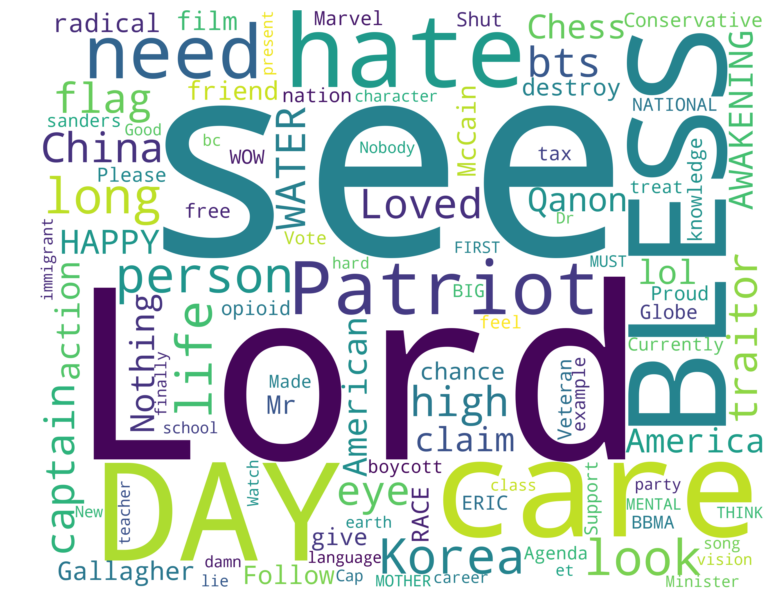

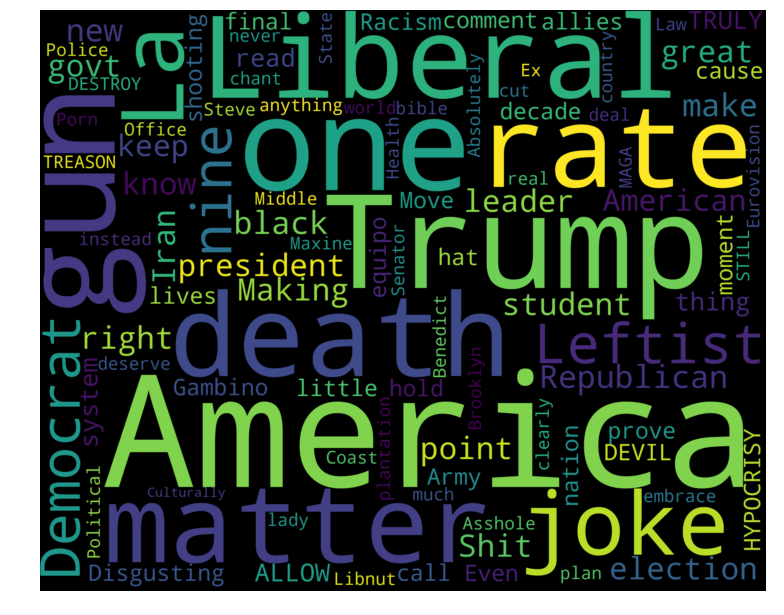

In [10]:
from wordcloud import WordCloud
import random

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color,
                      width=2500,
                      height=2000,
                      max_words=100
                     ).generate(words)
#     wordcloud.recolor(color_func = grey_color_func(word = words))
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

pos_term = [terms[0] for terms in semantic_sorted if terms[1] > 0 
            and not terms[0].startswith('@')]

neg_term = [terms[0] for terms in semantic_sorted if terms[1] < 0 
            and not terms[0].startswith('@')]

neutral_term = [terms[0] for terms in semantic_sorted if terms[1] == 0 
            and not terms[0].startswith('@')]

wordcloud_draw(pos_term, 'white')
wordcloud_draw(neg_term)




In [11]:
count = 0
target = []
for tweet in original_tweets:
    score = 0
    pos_counter = 0
    neg_counter = 0
    for word in semantic_sorted:
        if word[0].lower() in tweet.lower() and not word[0].isdigit() and len(word[0]) >= 3:
#             print(word)
            if word[1] > 0:
                pos_counter += 1
            if word[1] < 0:
                neg_counter += 1
        
            score += word[1]
    if(pos_counter > neg_counter or score > 0):
        count += 1
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'
    target.append(sentiment)

In [12]:
print(count)
print(len(original_tweets))
print(len(target))

98
966
966


In [13]:
# We create a pandas dataframe as follows:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
df = pd.DataFrame(data=[tweet for tweet in original_tweets], columns=['text'])
df['sentiment']  = np.array([sentiment for sentiment in target])

In [16]:
import re
from textblob import TextBlob


def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
#     print(clean_tweet(tweet))
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'Positive'
#     elif ( analysis.sentiment.polarity == 0):
#         return 'Neutral'
    else:
        return 'Negative'

def analyze_subject(tweet):
    '''
    Utility function to classify the subjectivity of a tweet
    using textblob.
    '''
#     print(clean_tweet(tweet))
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.subjectivity
#     if analysis.sentiment.subjectivity > 0.5:
#         return 'Subjective'
#     else:
#         return 'Not Subjective'



# We create a column with the result of the analysis:
df['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df['text'] ])
df['Subjective'] = np.array([ analyze_subject(tweet) for tweet in df['text'] ])

# We display the updated dataframe with the new column:
display(df[['text', 'SA', 'Subjective']].head())

pos_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Positive']
neg_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Negative']
# neu_tweets = [ tweet for index, tweet in enumerate(df['text']) if df['SA'][index] == 'Neutral']


print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(df['text'])))
print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(df['text'])))
# print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['text'])))

,text,SA,Subjective
0,"“believe Trump will fight for them” is exactly it because he’s not. Thanks to him, health care costs are going up, he won’t fight to lower prescription drug costs, he hasn’t even touched the opioid crisis he said he’d fix. Sit down with your con-artist talk and have all the seats https://t.co/9XaU0A2gs8",Negative,0.246296
1,"For #MothersDay I made a donation to Everytown, which has been winning legislative battles against the NRA and whose grassroots arm @MomsDemand is keeping America focused on the gun-violence epidemic. \n\nJoin me if you can! \n\nhttps://t.co/ZufRAdvfHF https://t.co/UOGncL7yna",Positive,0.750000
2,Trump's America. https://t.co/nslRE4hrIo,Negative,0.000000
3,"@vandersykes @bluespherevic @FoxNews @TomiLahren @WattersWorld If you were born in America than your not an immigrant, understand?",Negative,0.000000
4,"Trump’s decision to exit America from the Iran deal, formally named the Joint Comprehensive Plan of Action, pushed up the price of oil — Russia’s key export — to a three-year high https://t.co/ApNYPt1ru9",Positive,0.546667


Percentage of positive tweets: 57.2463768115942%
Percentage de negative tweets: 42.7536231884058%


In [17]:
df.head(50)

,text,sentiment,SA,Subjective
0,"“believe Trump will fight for them” is exactly it because he’s not. Thanks to him, health care costs are going up, he won’t fight to lower prescription drug costs, he hasn’t even touched the opioid crisis he said he’d fix. Sit down with your con-artist talk and have all the seats https://t.co/9XaU0A2gs8",Negative,Negative,0.246296
1,"For #MothersDay I made a donation to Everytown, which has been winning legislative battles against the NRA and whose grassroots arm @MomsDemand is keeping America focused on the gun-violence epidemic. \n\nJoin me if you can! \n\nhttps://t.co/ZufRAdvfHF https://t.co/UOGncL7yna",Negative,Positive,0.750000
2,Trump's America. https://t.co/nslRE4hrIo,Negative,Negative,0.000000
3,"@vandersykes @bluespherevic @FoxNews @TomiLahren @WattersWorld If you were born in America than your not an immigrant, understand?",Negative,Negative,0.000000
4,"Trump’s decision to exit America from the Iran deal, formally named the Joint Comprehensive Plan of Action, pushed up the price of oil — Russia’s key export — to a three-year high https://t.co/ApNYPt1ru9",Negative,Positive,0.546667
5,This race baiting imbecile had shoved her foot in her mouth so many times her throat has athletes foot. \n\nMaxine Waters explodes on House floor: I resent ‘making America great again’! (VIDEO) https://t.co/MwSPdUBljf,Negative,Positive,0.750000
6,"Turns out that during the election, the Russians bought Facebook ads mostly to promote the fake narrative that racism, especially white racism against blacks, remains a deep, festering problem in America. It's the same narrative democrats promote. Yet none dare call it collusion.",Negative,Negative,0.405000
7,"captain america coming out of the shadows was literally in the trailer but people still lost their shit when it happened in the cinema,, we love a powerful dramatic bitch",Negative,Positive,0.750000
8,"The Ex Resident Obama was never the leader of America because you can’t lead what you don’t love! Obama led the Progressive Globalist plot to destroy America. Thank God that on November 8 2016 Donald Trump ended his wicked agenda, and Libnuts are still in shock😂 @POTUS #MAGA",Negative,Positive,0.300000
9,Why is that even legal? https://t.co/55odrETrXc,Negative,Positive,0.200000


In [18]:
import pickle

def load_pickle(file_name):
    with open(file_name + '.pickle', 'rb') as file:
        classifier = pickle.load(file)
    return classifier

In [19]:
classifier = load_pickle('vec_clf')

In [20]:
# classifier.score(data_test, targets_test)
# predicted = classifier.predict(vectorized_data)
print(classifier)
def sentiment2target(sentiment):
    return {
        'Negative': 0,
        'Positive' : 1
    }[sentiment]

# Convert Classification into integer for speed and space efficiency reasons
targets_SA = df.SA.apply(sentiment2target)
targets_sentiment = df.sentiment.apply(sentiment2target)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [21]:
predicted = classifier.predict(df.text)

In [22]:
np.mean(predicted == targets_SA)

0.5227743271221532

In [23]:
np.mean(predicted == targets_sentiment)

0.8178053830227743

In [24]:
count_pre = 0
count_pos = 0
for pre in predicted:
    if pre == 1:
        count_pos += 1
        print(df.text[count_pre])
        print("")
    count_pre += 1

“believe Trump will fight for them” is exactly it because he’s not. Thanks to him, health care costs are going up, he won’t fight to lower prescription drug costs, he hasn’t even touched the opioid crisis he said he’d fix. Sit down with your con-artist talk and have all the seats https://t.co/9XaU0A2gs8

This race baiting imbecile had shoved her foot in her mouth so many times her throat has athletes foot. 

Maxine Waters explodes on House floor: I resent ‘making America great again’! (VIDEO) https://t.co/MwSPdUBljf

The Ex Resident Obama was never the leader of America because you can’t lead what you don’t love! Obama led the Progressive Globalist plot to destroy America. Thank God that on November 8 2016 Donald Trump ended his wicked agenda, and Libnuts are still in shock😂  @POTUS #MAGA

John McCain makes America great. Father, grandfather, Navy pilot, POW hero bound by honor, an incomparable and irrepressible statesman. Those who mock such greatness only humiliate themselves and the

In [42]:
print(count_pre)
print(count_pos)
print("Percentage of Positive tweets: ", str((count_pos/count_pre)*100), "%")
print("Percentage of Negative tweets: ", str(((count_pre-count_pos)/count_pre)*100), "%")

966
496
Percentage of Positive tweets:  51.345755693581786 %
Percentage of Negative tweets:  48.65424430641822 %
